# Setting

In [1]:
from pf_utils import DataManager, BacktestManager, FinancialRatios
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_comp = 'data/kospi200'

In [3]:
col_ticker = '종목코드'
col_date = 'date'

# Components

In [4]:
import pandas as pd
import re
from pf_utils import get_file_list

In [5]:
file = 'kospi200_components'
files = get_file_list(file, path_comp)
files

['kospi200_components_040102.csv',
 'kospi200_components_050103.csv',
 'kospi200_components_060102.csv',
 'kospi200_components_070102.csv',
 'kospi200_components_080102.csv',
 'kospi200_components_090102.csv',
 'kospi200_components_100104.csv',
 'kospi200_components_110103.csv',
 'kospi200_components_120102.csv',
 'kospi200_components_130102.csv',
 'kospi200_components_140102.csv',
 'kospi200_components_150102.csv',
 'kospi200_components_160104.csv',
 'kospi200_components_170102.csv',
 'kospi200_components_180102.csv',
 'kospi200_components_190102.csv',
 'kospi200_components_200102.csv',
 'kospi200_components_210104.csv',
 'kospi200_components_220103.csv',
 'kospi200_components_230102.csv',
 'kospi200_components_240102.csv']

In [6]:
get_date = lambda x: '20' + re.search(r'\_(\d{6})\.', x).group(1)

df_comp = pd.DataFrame()
for f in files:
    date = get_date(f)
    f = f'{path_comp}/{f}'
    df = pd.read_csv(f, dtype={col_ticker:str})
    df = df.assign(date=date)
    df_comp = pd.concat([df_comp, df])

df_comp[col_date] = pd.to_datetime(df_comp[col_date])

In [7]:
tickers_all = df_comp[col_ticker].unique()
len(tickers_all)

439

# Price

## Download

In [8]:
WidgetUniverse

In [9]:
start_date = df_comp[col_date].min().strftime('%Y-%m-%d')
end_date = df_comp[col_date].max().strftime('%Y-%m-%d')
start_date, end_date

('2004-01-02', '2024-01-02')

In [10]:
uv_k2hl = ['krx', 'kospi200_bt_prices_040102_241023.csv']

In [11]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [14]:
kw = dict(
    start_date=start_date, tickers=tickers_all,
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
k2hl.download(**kw) if WidgetUniverse.values(0) else None

REMINDER: 439 tickers set regardless of market


100%|█████████████████████████████████████████████████████████████| 439/439 [01:36<00:00,  4.55it/s]


1.6 mins elapsed, 18.0 secs paused (18.7%)
... done
426 assets from 2004-01-02 to 2024-10-23 downloaded.
kospi200_prices_040102_241023.csv saved
df_prices updated
Execution time of download: 96.92 secs


In [37]:
#k2hl.save()

kospi200_prices_bt_040102_241024.csv saved


In [12]:
df_k2hl = k2hl.df_prices

## Listing by Year

In [13]:
# drop tickers of no data
df_comp2 = df_comp.loc[df_comp[col_ticker].isin(df_k2hl.columns)]

In [14]:
for year in df_comp2[col_date].dt.year.unique():
    # get list of kospi200 in year
    t_all = df_comp2.loc[df_comp2[col_date].dt.year == year, col_ticker]
    # get tickers of non kospi200 in year and set their prices to None
    t_exc = df_k2hl.columns.difference(t_all)
    df_k2hl.loc[df_k2hl.index.year == year, t_exc] = None

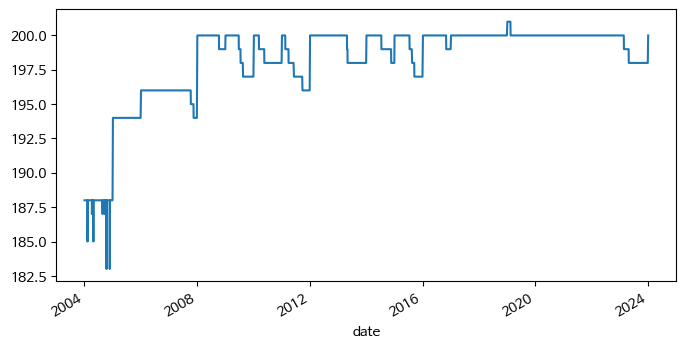

In [15]:
start, end = df_comp2[col_date].min(), df_comp2[col_date].max()
_ = df_k2hl.loc[start:end].notna().sum(axis=1).plot(figsize=(8,4))

In [16]:
#k2hl.df_prices.loc[start:end].notna().sum(axis=1).plot()

In [17]:
uv_k2hl

['krx', 'kospi200_bt_prices_040102_241023.csv']

In [21]:
file = 'kospi200_bt_prices_040102_241023.csv'
#df_k2hl.to_csv(f'{path_data}/{file}')

# Ratio

## Download

In [18]:
from pf_utils import get_date_minmax
start_date, end_date = get_date_minmax(df_k2hl, date_format='%Y-%m-%d')
start_date, end_date

('2004-01-02', '2024-10-23')

In [19]:
WidgetUniverse

In [20]:
file = 'kospi200_bt_ratios.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 426 stocks from 2004-01-31 to 2024-09-30 loaded


In [32]:
tickers = df_k2hl.columns.to_list()

kw = dict(
    freq = 'm',
    close_today = WidgetUniverse.values(1)
)
fr.download(tickers, start_date, end_date, **kw) if WidgetUniverse.values(0) else None

100%|███████████████████████████████████████████████████████████| 426/426 [3:51:37<00:00, 32.62s/it]


231.6 mins elapsed, 6.8 mins paused (2.9%)
Financial ratios of 426 stocks from 2004-01-31 to 2024-09-30 downloaded
kospi200_bt_ratios_240930.csv saved


In [21]:
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-09-30


ticker
005440    0.000000
085310    0.003436
007860    0.006873
001230    0.010309
010060    0.013746
            ...   
003670    0.986254
329180    0.989691
450080    0.993127
377300    0.996564
004800    1.000000
Name: PER, Length: 292, dtype: float64

In [22]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2004-01-31    1.669885
        2004-02-29    1.763447
        2004-03-31    1.759707
        2004-04-30    1.782042
        2004-05-31    1.773187
                        ...   
009970  2024-05-31    0.412358
        2024-06-30    0.395185
        2024-07-31    0.376691
        2024-08-31    0.381042
        2024-09-30    0.412514
Name: PER, Length: 87257, dtype: float64

In [23]:
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2004-01-31,2004-01-31,2004-01-31,2004-01-31,2004-01-31,2004-01-31
end,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30
mean,64684.1,35.8,1.6,5342.9,1.7,849.3
std,17561.2,26.8,0.4,1537.8,0.6,251.7


In [24]:
df_ratios = fr.df_ratios

# Usage

## Price

In [25]:
uv_k2hl = ['krx', 'kospi200_bt_prices_040102_241023.csv']

In [26]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [27]:
df_k2hl = k2hl.df_prices.ffill()
assetnames_k2hl = k2hl.get_names()

ERROR from get_names: '060000'


## Ratio

In [28]:
file = 'kospi200_bt_ratios_040131_240930.csv'

In [29]:
fr = FinancialRatios(file, path_data)

Financial ratios of 426 stocks from 2004-01-31 to 2024-09-30 loaded


In [30]:
df_ratios = fr.df_ratios

*Interpolate & Reshape*

In [31]:
df_p = fr.util_reshape(df_k2hl)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

PER interpolated from 2004-02-02 to 2024-10-23
PBR interpolated from 2004-02-02 to 2024-10-23


## Backtest

In [40]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 245,
    asset_names = assetnames_k2hl
)

In [41]:
bm = BacktestManager(df_k2hl, **kwargs_bm)

lags = dict(lookback='12M', lag='20D')

bm.benchmark_ticker(**lags)

426 assets from 2004-01-02 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [42]:
select='Momentum'
kwargs_build = dict(
    name=select, select=select, weigh='Equally', 
    n_assets=20, freq='M', **lags
)
bm.build(**kwargs_build)

In [43]:
fratio = 'PER'
kwargs_build = dict(
    name=fratio, select='f-ratio', weigh='Equally', 
    n_assets=20, freq='Y', lookback=0,
    df_ratio=fratios_dict[r], ratio_descending=True
)
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, Momentum, PER


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.20s/it]

Returning stats


,PER,Momentum,KODEX200
start,2004-01-01,2004-01-01,2004-01-01
end,2024-10-23,2024-10-23,2024-10-23
total_return,10.954451,6.373214,3.117451
cagr,0.126622,0.100762,0.070372
calmar,0.19959,0.174172,0.133579
max_drawdown,-0.634414,-0.578519,-0.52682
avg_drawdown,-0.057893,-0.058004,-0.033954
avg_drawdown_days,86.761905,92.878378,66.31068
daily_vol,0.360001,0.234503,0.196613
daily_sharpe,0.482214,0.535155,0.451214


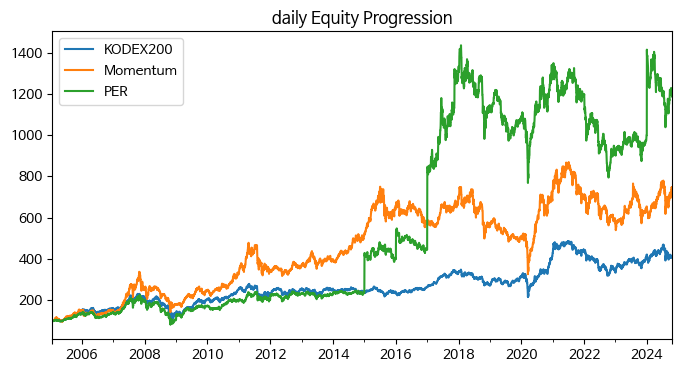

In [44]:
bm.run(stats_sort_by='cagr', figsize=(8,4))

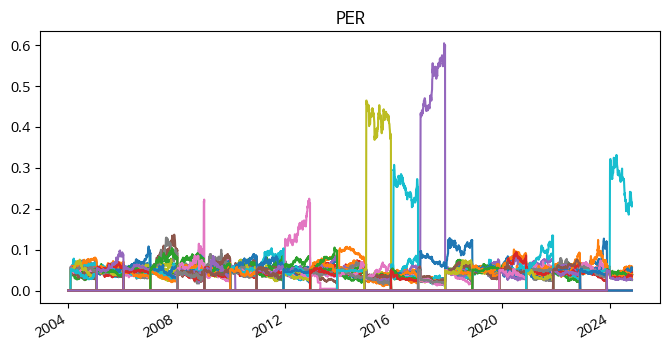

In [45]:
bm.plot_security_weights(2, legend=False, figsize=(8,4))